Import libraries

In [1]:
!pip install split_folders

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,callbacks
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
plant='pepper'
ds_path=fr"C:\projects\potato_disease_classification\mine\dataset\{plant}"

In [11]:
# # To split dataset into training, validation, and test set
# splitfolders.ratio(r"C:\projects\potato_disease_classification\mine\dataset\tomato\tomato_classes",
#                    output=r"C:\projects\potato_disease_classification\mine\dataset\tomato\datasets",
#                    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [12]:
# To split dataset into training, validation, and test set
splitfolders.ratio(fr"{ds_path}\{plant}_classes",
                   output=fr"{ds_path}\datasets",
                   seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 2475 files [00:07, 340.00 files/s]


Define veriables 

In [13]:
img_size=256
batch_size=32

In [14]:
dirs=[x[1] for x in os.walk(fr"{ds_path}\datasets")]
dirs[0]

['test', 'train', 'val']

In [15]:
for i in range(3):
    img=ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    brightness_range=(0.2,1.0),
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
    )
    
    globals()[f"{dirs[0][i]}_generator"]= img.flow_from_directory(
        fr"{ds_path}\datasets/{dirs[0][i]}",
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode="sparse",
#         save_to_dir="C:\\Code\\potato-disease-classification\\training\\AugmentedImages"
    )

Found 250 images belonging to 2 classes.
Found 1979 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


Display the classes (folders) in dataset

In [16]:
train_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [13]:
test_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [14]:
val_generator.class_indices

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [17]:
class_names = list(train_generator.class_indices.keys())
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

Build the model

In [16]:
model=models.Sequential([
    layers.Conv2D(32,(3,3), activation='relu',input_shape=(img_size,img_size,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')
])

model.build(input_shape=(batch_size,img_size,img_size,3))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Early Stopping

In [19]:
es=callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    batch_size=32,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    epochs=50,
#     ,callbacks=[es]
)

Epoch 1/50
62/62 [==============================] - 395s 6s/step - loss: 0.6686 - accuracy: 0.6079 - val_loss: 0.5356 - val_accuracy: 0.7480
Epoch 2/50
62/62 [==============================] - 351s 6s/step - loss: 0.4475 - accuracy: 0.8206 - val_loss: 0.3062 - val_accuracy: 0.9106
Epoch 3/50
62/62 [==============================] - 344s 6s/step - loss: 0.2589 - accuracy: 0.9186 - val_loss: 0.1865 - val_accuracy: 0.9309
Epoch 4/50
62/62 [==============================] - 274s 4s/step - loss: 0.2050 - accuracy: 0.9262 - val_loss: 0.1244 - val_accuracy: 0.9512
Epoch 5/50
62/62 [==============================] - 359s 6s/step - loss: 0.1420 - accuracy: 0.9570 - val_loss: 0.1138 - val_accuracy: 0.9553
Epoch 6/50
62/62 [==============================] - 352s 6s/step - loss: 0.1361 - accuracy: 0.9666 - val_loss: 0.0692 - val_accuracy: 0.9756
Epoch 7/50
62/62 [==============================] - 334s 5s/step - loss: 0.0843 - accuracy: 0.9808 - val_loss: 0.1013 - val_accuracy: 0.9634
Epoch 8/50
62

Evaluate the model

In [21]:
score = model.evaluate(test_generator)

8/8 [==============================] - 30s 4s/step - loss: 0.0235 - accuracy: 0.9840


Plotting the history of the training model

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

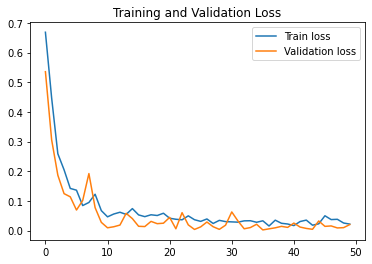

In [25]:
plt.plot( loss,label='Train loss')
plt.plot( val_loss,label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

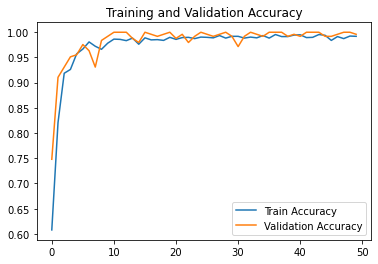

In [26]:
plt.plot(acc,label='Train Accuracy')
plt.plot( val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Prediction using test dataset

In [27]:
# prediction function
def pred_img(img):
#     add one mor dim for image array
    img_array=tf.expand_dims(img,0)
    
#     predict the image
    pred=model.predict(img_array)
    
#     Select the class of the predicted image
    pred_class=class_names[np.argmax(pred[0])]
#     Accuracy of the prediction
    confidence=round((np.max(pred[0])*100),2)
    
    return pred_class, confidence

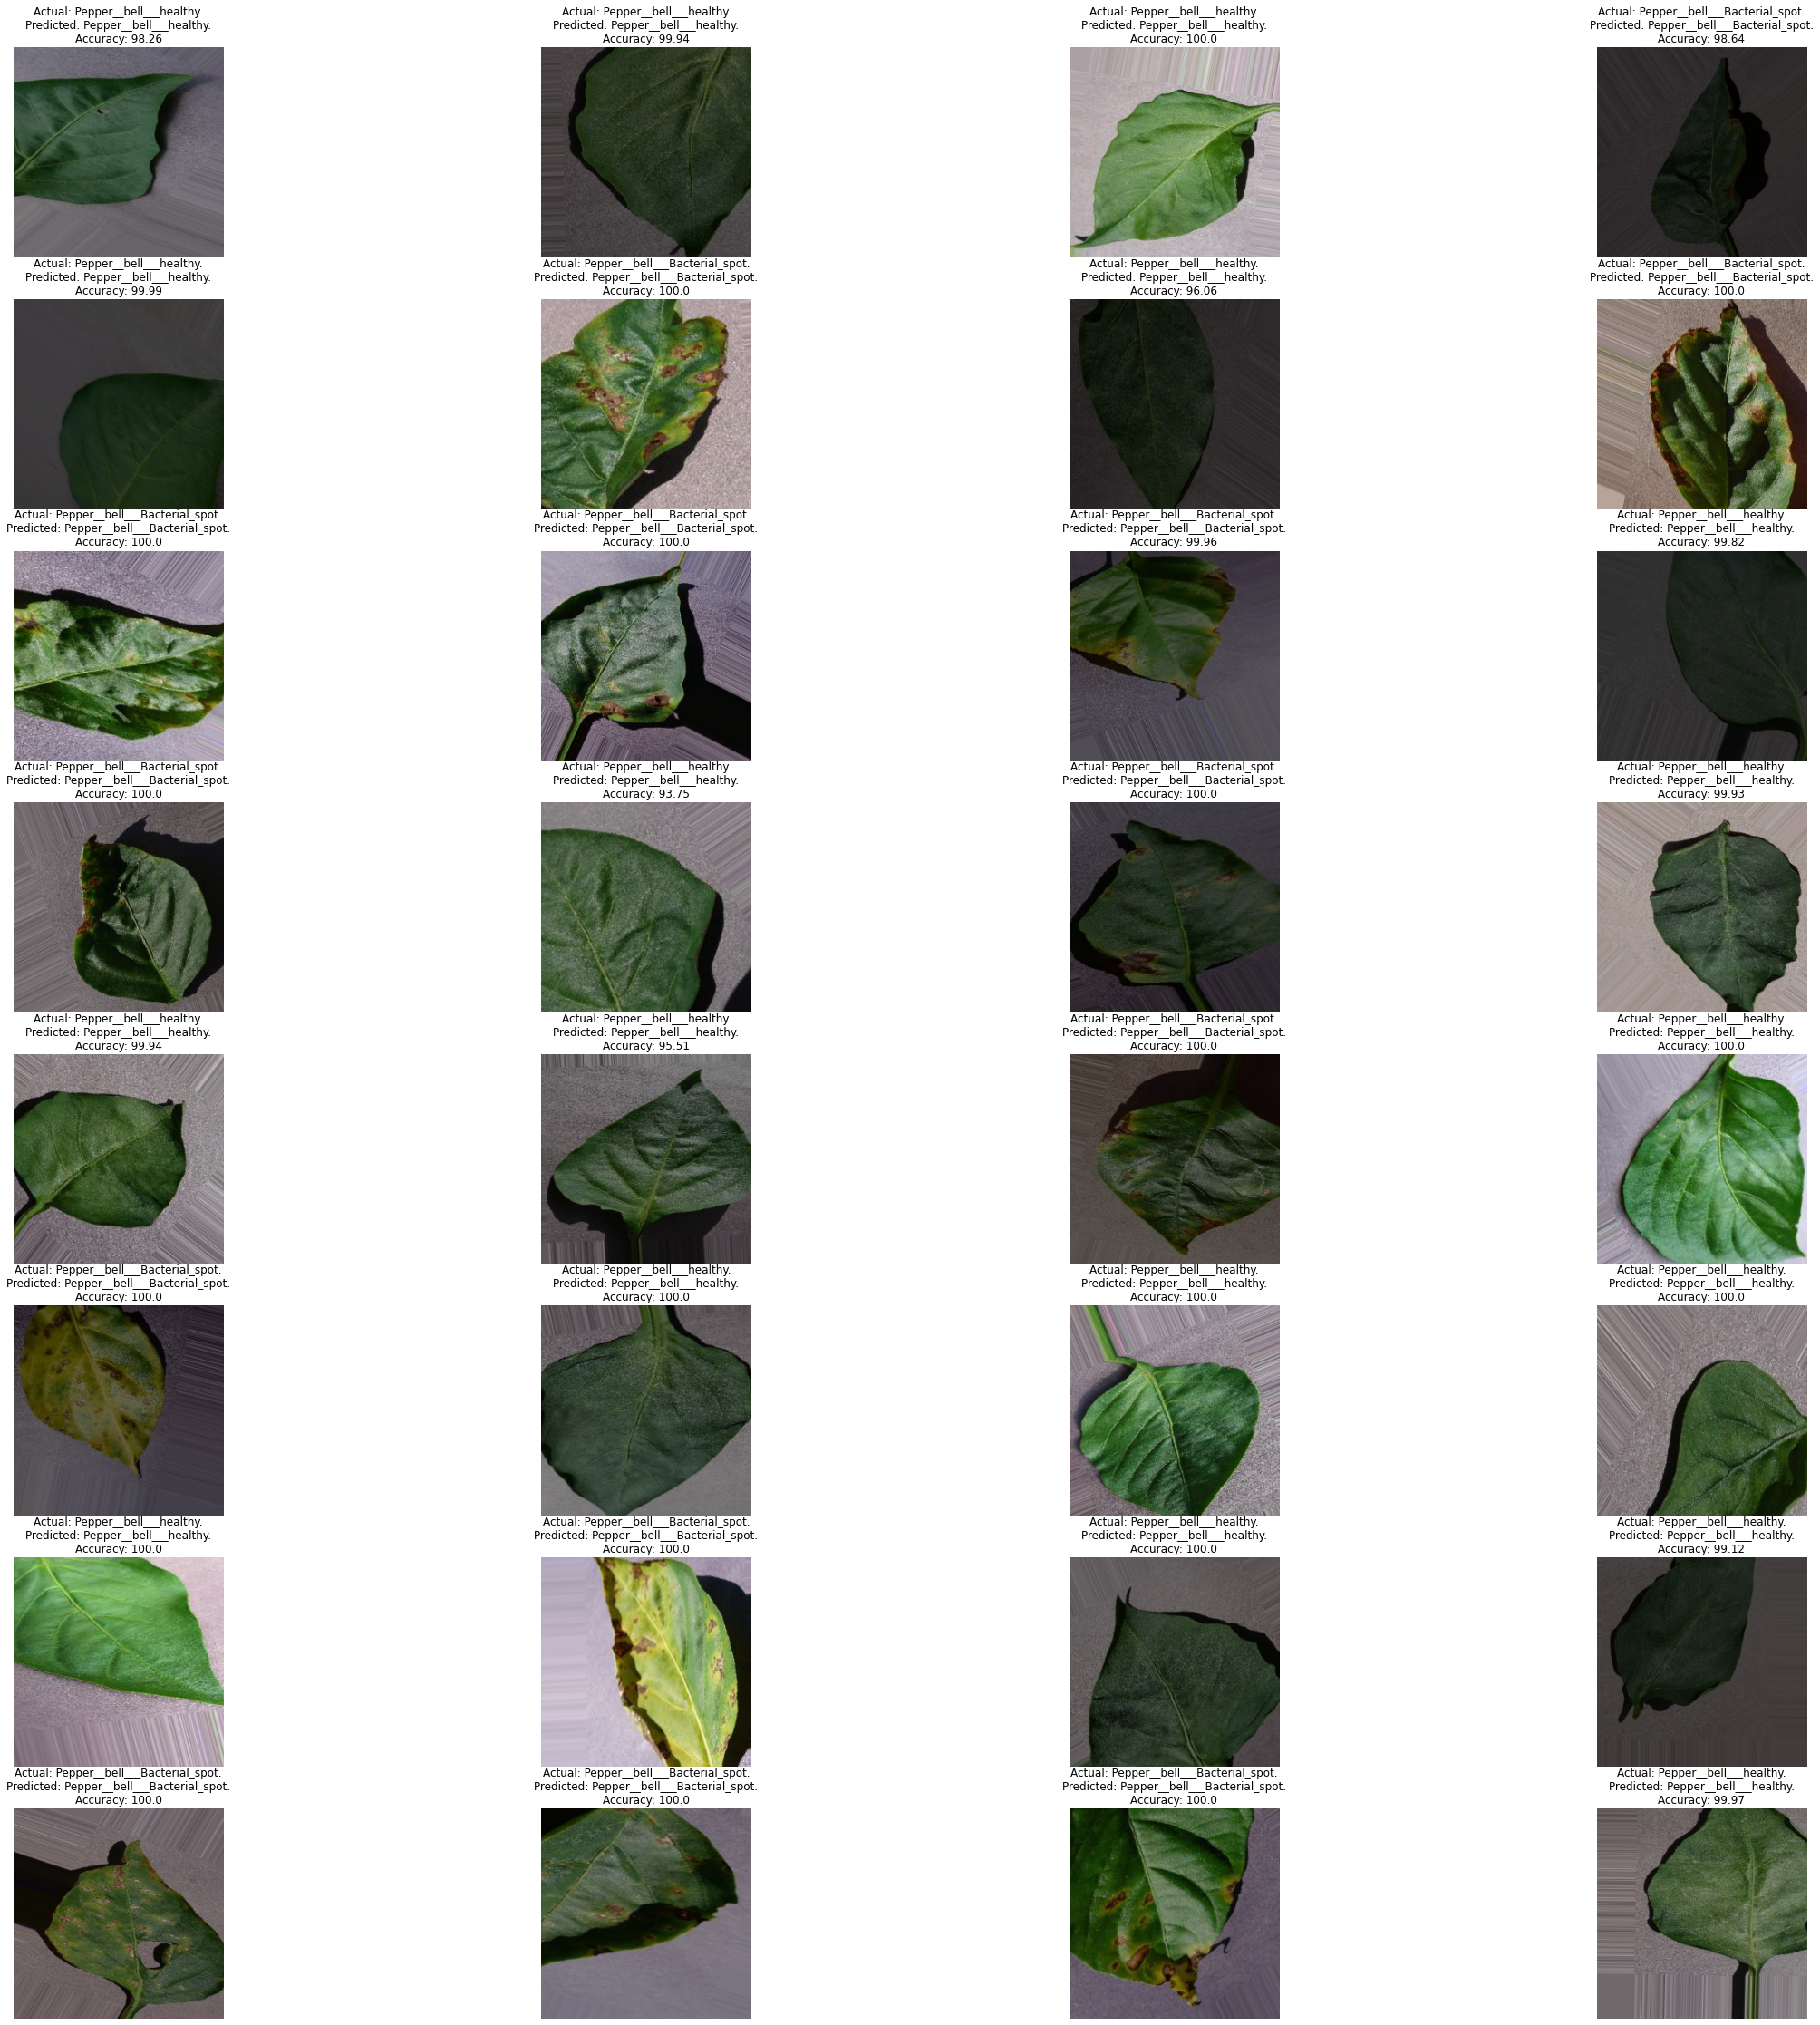

In [28]:
plt.figure(figsize=(40,40))

batch__size=len(test_generator.__getitem__(1)[0])
for i in range (0,batch__size):
#     image array in test_generator first batch
    image=test_generator.__getitem__(1)[0][i]
#     label number in test_generator first batch
    label=test_generator.__getitem__(1)[1][i]
#    predict the image and get the predicted class and the accuracy
    pred_class, confidence = pred_img(image)
#    the actual class of the image
    actual_class= class_names[int(label)]
#    plot the image with its info
    col=int(batch__size/4)
    ax=plt.subplot(col,4,i+1)
    plt.imshow(image)
    plt.title(
        f'Actual: {actual_class}.\nPredicted: {pred_class}.\nAccuracy: {confidence}'
    )
    plt.axis('off')

Save the model

In [33]:
model.save(fr'.\models\{plant}_disease_classification\{plant}_PDC_ImageDataGenerator')
model.save(fr".\models\{plant}_disease_classification\{plant}_PDC_ImageDataGenerator.h5")

INFO:tensorflow:Assets written to: .\models\pepper_disease_classification\pepper_PDC_ImageDataGenerator\assets


Load the model

In [24]:
model_loaded = tf.keras.models.load_model(fr'.\models\{plant}_disease_classification\{plant}_PDC_ImageDataGenerator')

In [25]:
# prediction function
def pred_img(img):
#     add one mor dim for image array
    img_array=tf.expand_dims(img,0)
    
#     predict the image
    pred=model_loaded.predict(img_array)
    
#     Select the class of the predicted image
    pred_class=class_names[np.argmax(pred[0])]
#     Accuracy of the prediction
    confidence=round((np.max(pred[0])*100),2)
    
    return pred_class, confidence

In [26]:
pred_class, confidence = pred_img('img.JPG')
pred_class

ValueError: in user code:

    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\husam\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
